## Notebook to show posts creation trends for tag

### Description
This notebook shows top trending tags and progress, based on aggregations done in the previous notebook.
Top trending tags are defined as tags which `TagShare` share increased the most for the observation period, e.g. 3 years. 

### Input
This notebook takes as an input `posts_creation_trends.csv` file, produced by the previous step.

### Output
This notebook does not produce any files. 

### Setup

In [55]:
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go
import plotly.io as pio

from config import get_file_path

pio.renderers.default = 'plotly_mimetype+notebook_connected' # To make possible render charts inside Jupyter

In [56]:
# Utility function for working with year-month operations
def subtract_months(year_month: str, month_count: int) -> str:
    date = datetime.strptime(year_month, "%Y-%m")
    new_date = date - relativedelta(months=month_count)
    return new_date.strftime("%Y-%m")

def past_years_dates(year_month: str, years: int) -> list[str]:
    months = range(0, years * 12 + 1)
    return list([subtract_months(year_month, month) for month in months])

In [57]:
posts_creation_trends_path = get_file_path('posts_creation_trends.csv')
posts_creation_trends_df = pd.read_csv(posts_creation_trends_path)
posts_creation_trends_df

,Tag,CreationDate,TagPostsCreated,TagTotalPostsCreated,PostsCreated,TotalPostsCreated,TagShare,TagRank
0,a,2020-01,10,10.0,100,100.0,10.000000,3.0
1,a,2020-02,10,20.0,100,200.0,10.000000,3.0
2,a,2020-03,10,30.0,100,300.0,10.000000,3.0
3,a,2020-04,10,40.0,100,400.0,10.000000,3.0
4,a,2020-05,10,50.0,100,500.0,10.000000,3.0
...,...,...,...,...,...,...,...,...
67,c,2021-08,40,1040.0,200,2800.0,37.142857,1.0
68,c,2021-09,40,1080.0,200,3000.0,36.000000,2.0
69,c,2021-10,40,1120.0,200,3200.0,35.000000,2.0
70,c,2021-11,40,1160.0,200,3400.0,34.117647,2.0


### Calculate delta for tag share and tag rank for observation period

In [58]:
def delta_by(df, source_column: str, multiplier: int = 1):
    start_column = f'Start{source_column}'
    end_column = f'End{source_column}'
    
    def extract_first_last(x):
        return pd.Series([x.iloc[0], x.iloc[-1]], index=[start_column, end_column])

    delta_df = df.\
        groupby('Tag')[source_column].\
        apply(extract_first_last).\
        unstack()
    
    delta_df[f'{source_column}Delta'] = multiplier * (delta_df[end_column] - delta_df[start_column])
    return delta_df

In [59]:
observation_period_years = 3
start_date = posts_creation_trends_df["CreationDate"].max()
dates = past_years_dates(start_date, observation_period_years)

print(f'Start date: {start_date}')
print(f'Dates: {dates}')

Start date: 2021-12
Dates: ['2021-12', '2021-11', '2021-10', '2021-09', '2021-08', '2021-07', '2021-06', '2021-05', '2021-04', '2021-03', '2021-02', '2021-01', '2020-12', '2020-11', '2020-10', '2020-09', '2020-08', '2020-07', '2020-06', '2020-05', '2020-04', '2020-03', '2020-02', '2020-01', '2019-12', '2019-11', '2019-10', '2019-09', '2019-08', '2019-07', '2019-06', '2019-05', '2019-04', '2019-03', '2019-02', '2019-01', '2018-12']


In [60]:
latest_posts_creation_trends_df = posts_creation_trends_df[posts_creation_trends_df["CreationDate"].isin(dates)]

tag_share_delta_df = delta_by(latest_posts_creation_trends_df, 'TagShare')
tag_rank_delta_df = delta_by(latest_posts_creation_trends_df, 'TagRank', -1) # Multiply delta by -1 because rank value increase has opposite meaning then in other metric cases

latest_tags_trends_delta_df =  tag_share_delta_df. \
    merge(tag_rank_delta_df, on='Tag', how='inner'). \
    reset_index()

### Find top trending tags

In [61]:
top_tags_trends_delta_df = latest_tags_trends_delta_df.sort_values(by='TagShareDelta', ascending=False)[0:20]
top_tags_trends_delta_df

,Tag,StartTagShare,EndTagShare,TagShareDelta,StartTagRank,EndTagRank,TagRankDelta
0,a,10.0,40.000000,30.000000,3.0,1.0,2.0
1,b,30.0,26.666667,-3.333333,2.0,3.0,-1.0
2,c,60.0,33.333333,-26.666667,1.0,2.0,-1.0


## Show charts for top trending tags

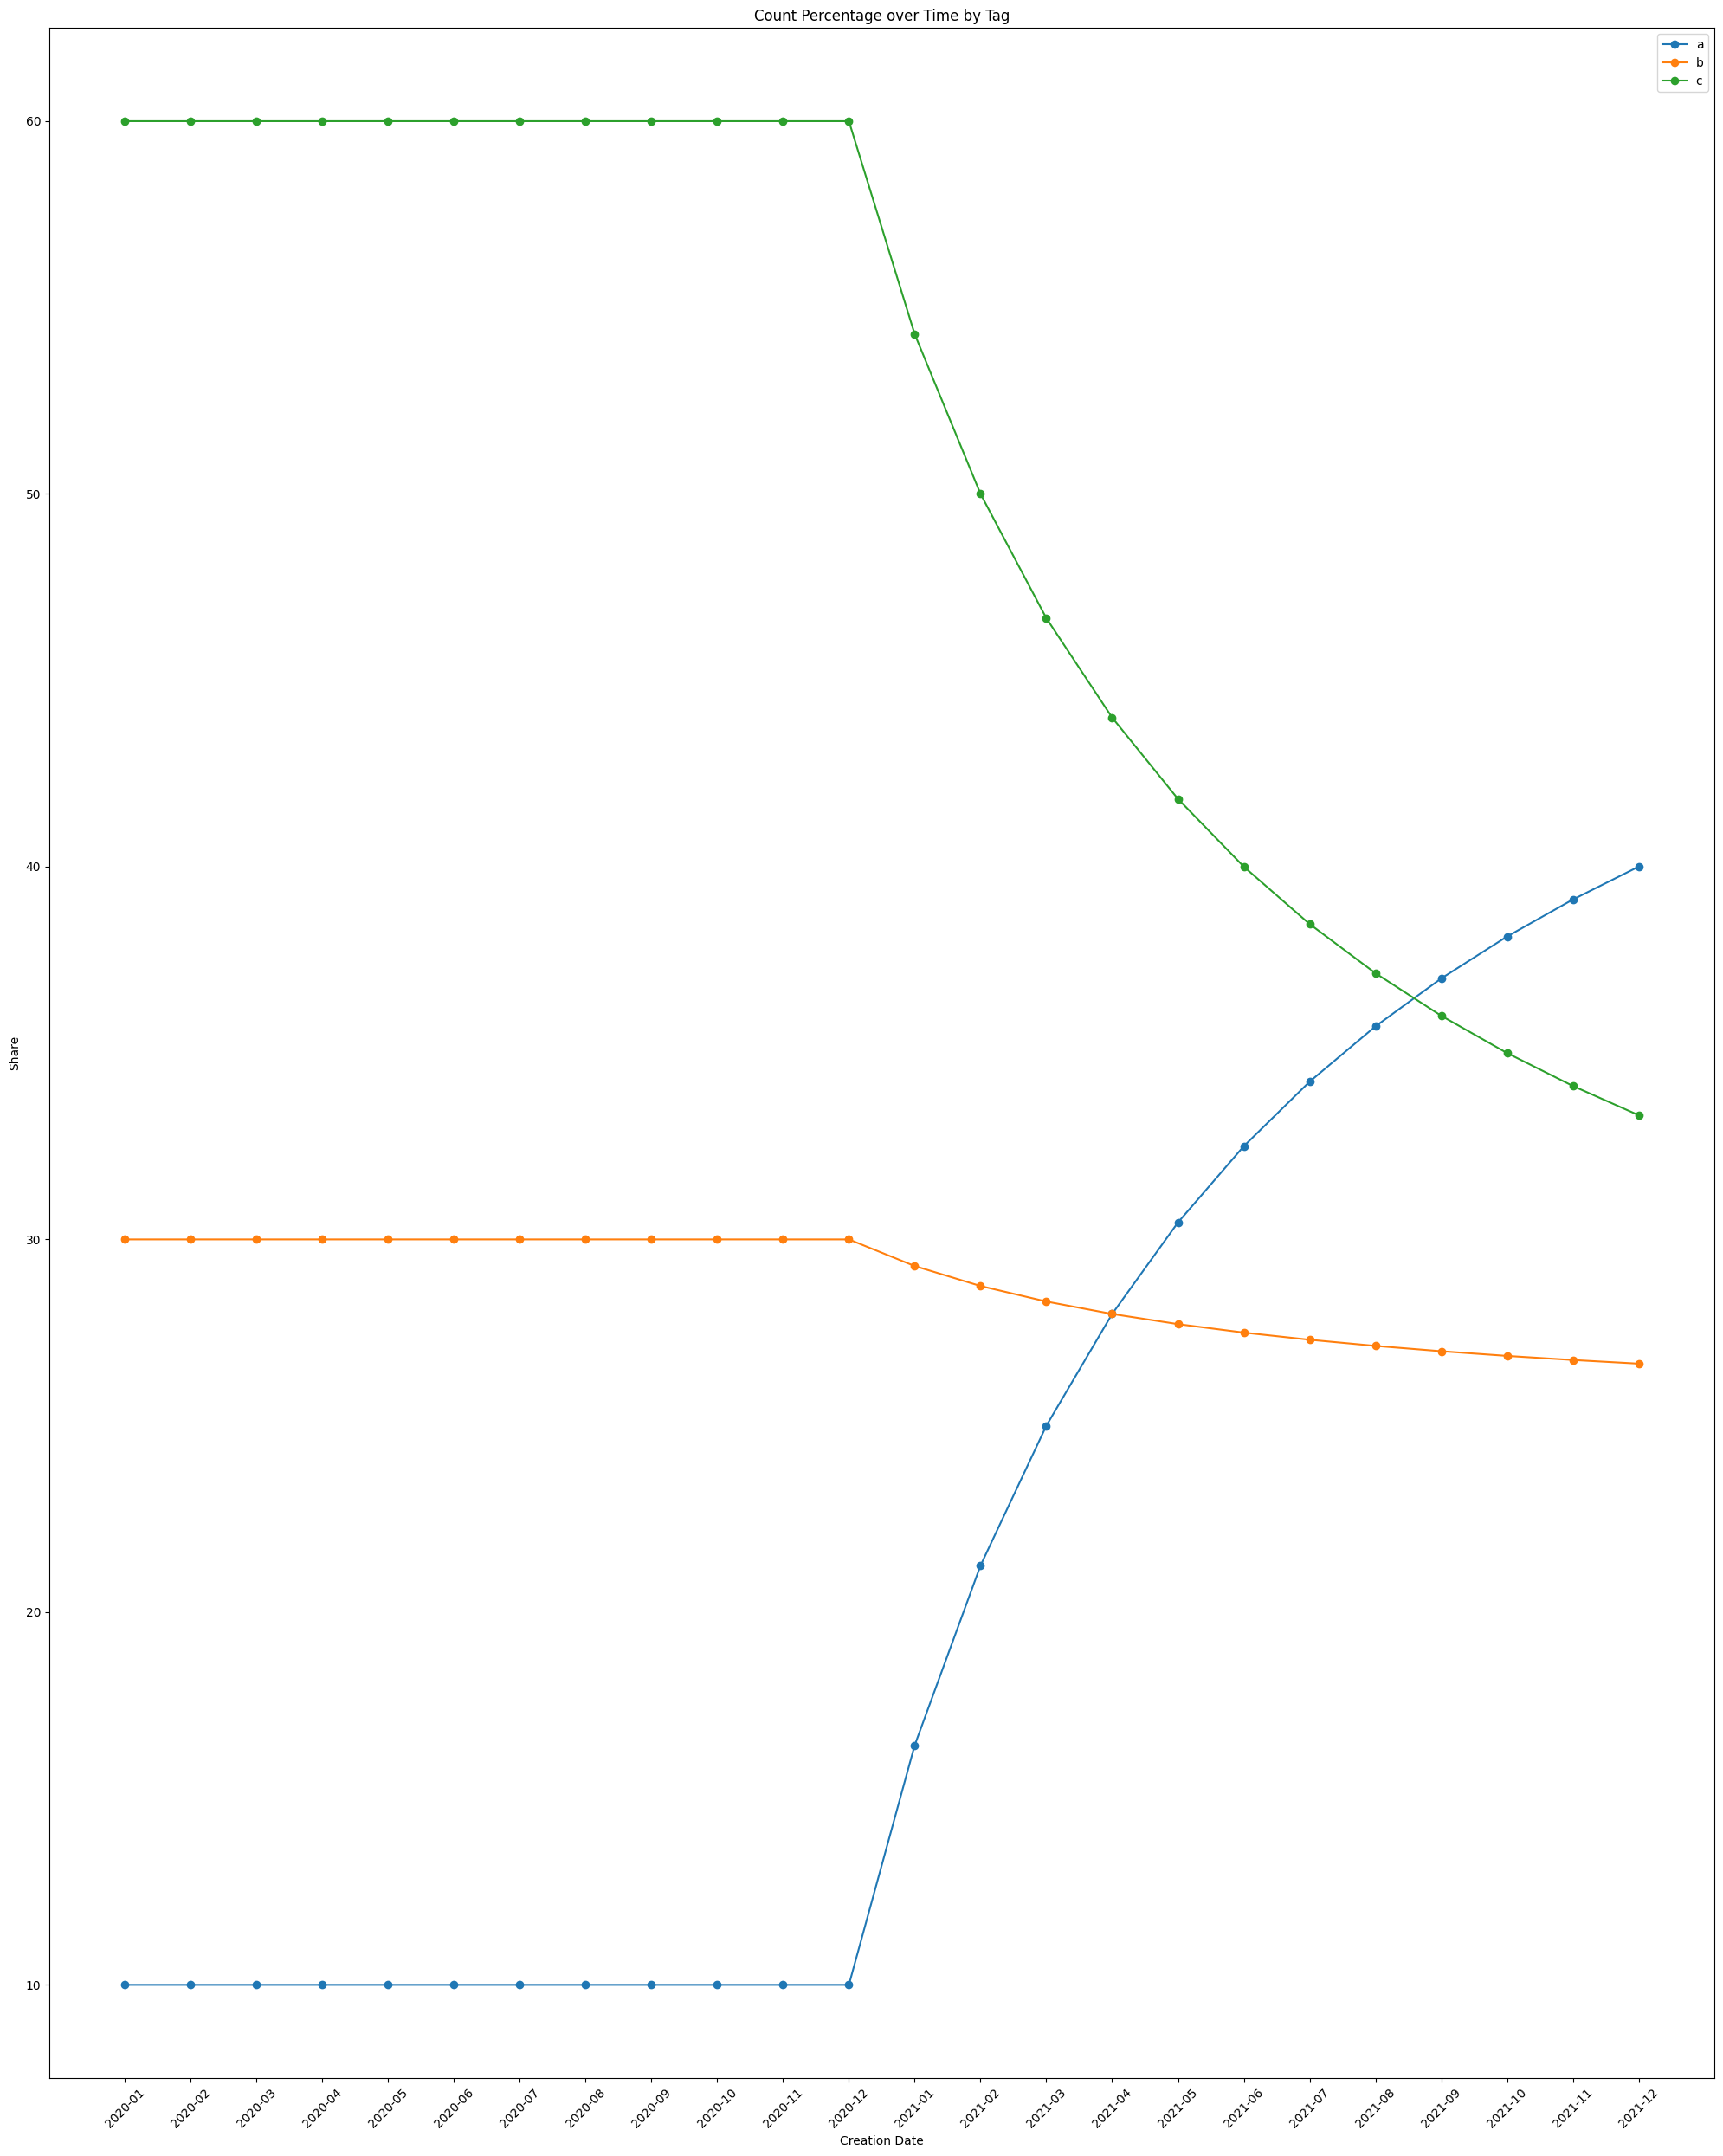

In [62]:
import matplotlib.pyplot as plt

top_trending_tags = list(top_tags_trends_delta_df['Tag'])

# [-36:] - take data fro last 3 years to be aligned
df = posts_creation_trends_df[posts_creation_trends_df['Tag'].isin(top_trending_tags)].\
    groupby('Tag').\
    agg({'TagShare': lambda x: list(x)[-36:], 'CreationDate': lambda x: list(x)[-36:]}).\
    reset_index()

fig, ax = plt.subplots(figsize=(20, 25))

for index, row in df.iterrows():
    ax.plot(row['CreationDate'], row['TagShare'], label=row['Tag'], marker='o')

ax.set_xlabel('Creation Date')
ax.set_ylabel('Share')
ax.set_title('Count Percentage over Time by Tag')
ax.legend()

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [68]:
top_trending_tags = list(top_tags_trends_delta_df['Tag'])

months = 12 * observation_period_years
tag_trends_timeline_df = posts_creation_trends_df[posts_creation_trends_df['Tag'].isin(top_trending_tags)].\
    groupby('Tag').\
    agg(
        {
            'TagShare': lambda x: list(x)[-months:],
            'TagRank': lambda x: list(x)[-months:],
            'CreationDate': lambda x: list(x)[-months:]
        }
    ).\
    reset_index()
tag_trends_timeline_df

,Tag,TagShare,TagRank,CreationDate
0,a,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[2020-01, 2020-02, 2020-03, 2020-04, 2020-05, ..."
1,b,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[2020-01, 2020-02, 2020-03, 2020-04, 2020-05, ..."
2,c,"[60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[2020-01, 2020-02, 2020-03, 2020-04, 2020-05, ..."


In [69]:
fig = go.Figure()

for index, row in tag_trends_timeline_df.iterrows():
    fig.add_trace(go.Scatter(x=row['CreationDate'],
                             y=row['TagShare'],
                             mode='lines+markers',
                             name=row['Tag']))

fig.update_layout(title='Share over time by Tag',
                  xaxis_title='Creation Date',
                  yaxis_title='Tag share',
                  legend_title='Tag',
                  width=1200,
                  height=600)

fig.show()

In [73]:
# Initialize a plotly figure
rank_fig = go.Figure()

# Loop through each row in the DataFrame and add a line to the figure for each
for index, row in tag_trends_timeline_df.iterrows():
    rank_fig.add_trace(go.Scatter(x=row['CreationDate'],
                             y=row['TagRank'],
                             mode='lines+markers', # This will create both lines and markers on each point
                             name=row['Tag'])) # Use the Tag column for the legend

# Update layout options as needed
rank_fig.update_layout(title='Rank over Time by Tag',
                  xaxis_title='Creation Date',
                  yaxis_title='TagRank',
                  legend_title='Tag',
                 yaxis=dict(autorange='reversed'),
                  width=1200,
                  height=600)

# Show the figure
rank_fig.show()